In [76]:
#pip install bs4
#pip intsall tqdm
#pip install nltk
#pip install skimage
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#nltk.download('stopwords')
#nltk.download('punkt')

In [77]:
import tensorflow as tf
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.applications import densenet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import xml.etree.ElementTree as ET
import os
import cv2
from wordcloud import WordCloud
import re
# extract the raw data
import pandas as pd
from tqdm import tqdm
import os
import xml.etree.ElementTree as ET
from PIL import Image
from bs4 import BeautifulSoup
from collections import defaultdict
import itertools
from collections import Counter

In [78]:
# from google.colab import drive
# drive.mount('/content/drive')

In [79]:


###########################################
## CHANGE THIS PATHS BASED ON YOUR SYSTEM
HOME_PATH = os.path.expanduser(f'~')
USERNAME = os.path.split(HOME_PATH)[1]
REPOSITORY_PATH='repositories/budai4medtech/amir/'
FULL_REPO_PATH = HOME_PATH+'/'+REPOSITORY_PATH
FULL_DATASET_PATH = FULL_REPO_PATH  + 'datasets/'

print(f'FULL_DATASET_PATH: {FULL_DATASET_PATH}' )

# extracting data from the xml documents
# directory = '/content/drive/MyDrive/image/ecgen-radiology'
directory = FULL_DATASET_PATH + 'ecgen-radiology'



FULL_DATASET_PATH: /home/mxochicale/repositories/budai4medtech/amir/datasets/


In [80]:
n=0
for filename in tqdm(os.listdir(directory)):
    if filename.endswith(".png"):
        n+=1
print(n)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11425/11425 [00:00<00:00, 1688153.43it/s]

7470


In [81]:
#select raw text in report

img = []
img_impression = []
img_finding = []
for filename in tqdm(os.listdir(directory)):
    if filename.endswith(".xml"):
        f = directory + '/' + filename
        tree = ET.parse(f)
        root = tree.getroot()
        for child in root:
            if child.tag == 'MedlineCitation':
                for attr in child:
                    if attr.tag == 'Article':
                        for i in attr:
                            if i.tag == 'Abstract':
                                for name in i:
                                    if name.get('Label') == 'FINDINGS':
                                        finding=name.text

        for p_image in root.findall('parentImage'):

            img.append(p_image.get('id'))
            img_finding.append(finding)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11425/11425 [00:00<00:00, 18151.54it/s]


In [82]:
dataset = pd.DataFrame()
dataset['Image_path'] = img
dataset['Finding'] = img_finding

In [83]:
dataset.head(5)

,Image_path,Finding
0,CXR4_IM-2050-1001,There are diffuse bilateral interstitial and a...
1,CXR4_IM-2050-2001,There are diffuse bilateral interstitial and a...
2,CXR3265_IM-1551-1001,The heart size and mediastinal contours appear...
3,CXR3265_IM-1551-2001,The heart size and mediastinal contours appear...
4,CXR3044_IM-1418-1001,The XXXX examination consists of frontal and l...


In [84]:
print('Dataset Shape:', dataset.shape)

Dataset Shape: (7470, 2)


In [85]:
def absolute_path(x):
    '''Makes the path absolute '''
    x = directory +'/'+ x + ".png"
    return x

dataset['Image_path'] = dataset['Image_path'].apply(lambda x : absolute_path(x)) # making the paths absolute



In [86]:
dataset.head(5)

,Image_path,Finding
0,/home/mxochicale/repositories/budai4medtech/am...,There are diffuse bilateral interstitial and a...
1,/home/mxochicale/repositories/budai4medtech/am...,There are diffuse bilateral interstitial and a...
2,/home/mxochicale/repositories/budai4medtech/am...,The heart size and mediastinal contours appear...
3,/home/mxochicale/repositories/budai4medtech/am...,The heart size and mediastinal contours appear...
4,/home/mxochicale/repositories/budai4medtech/am...,The XXXX examination consists of frontal and l...


In [89]:
def image_desc_plotter(data, n, rep):
    count = 1
    fig = plt.figure(figsize=(10,20))

    if rep == 'finding':

        for filename in data['Image_path'].values[95:100]:

            findings = list(data["Finding"].loc[data["Image_path"] == filename].values)
            print(filename)

            img = cv2.imread(filename)
            ax = fig.add_subplot(n, 2 , count , xticks=[], yticks=[])
            ax.imshow(img)
            count += 1
            ax = fig.add_subplot(n ,2 ,count)
            plt.axis('off')
            ax.plot()
            ax.set_xlim(0,1)
            ax.set_ylim(0, len(findings))
            for i, f in enumerate(findings):
                ax.text(0,i,f,fontsize=20)
            count += 1
        plt.show()

    else:
        print("Enter a valid String")

/home/mxochicale/repositories/budai4medtech/amir/datasets/ecgen-radiology/CXR2562_IM-1065-1001.png
/home/mxochicale/repositories/budai4medtech/amir/datasets/ecgen-radiology/CXR2562_IM-1065-3001.png
/home/mxochicale/repositories/budai4medtech/amir/datasets/ecgen-radiology/CXR1506_IM-0330-1001.png
/home/mxochicale/repositories/budai4medtech/amir/datasets/ecgen-radiology/CXR1506_IM-0330-2001.png
/home/mxochicale/repositories/budai4medtech/amir/datasets/ecgen-radiology/CXR254_IM-1051-1001.png


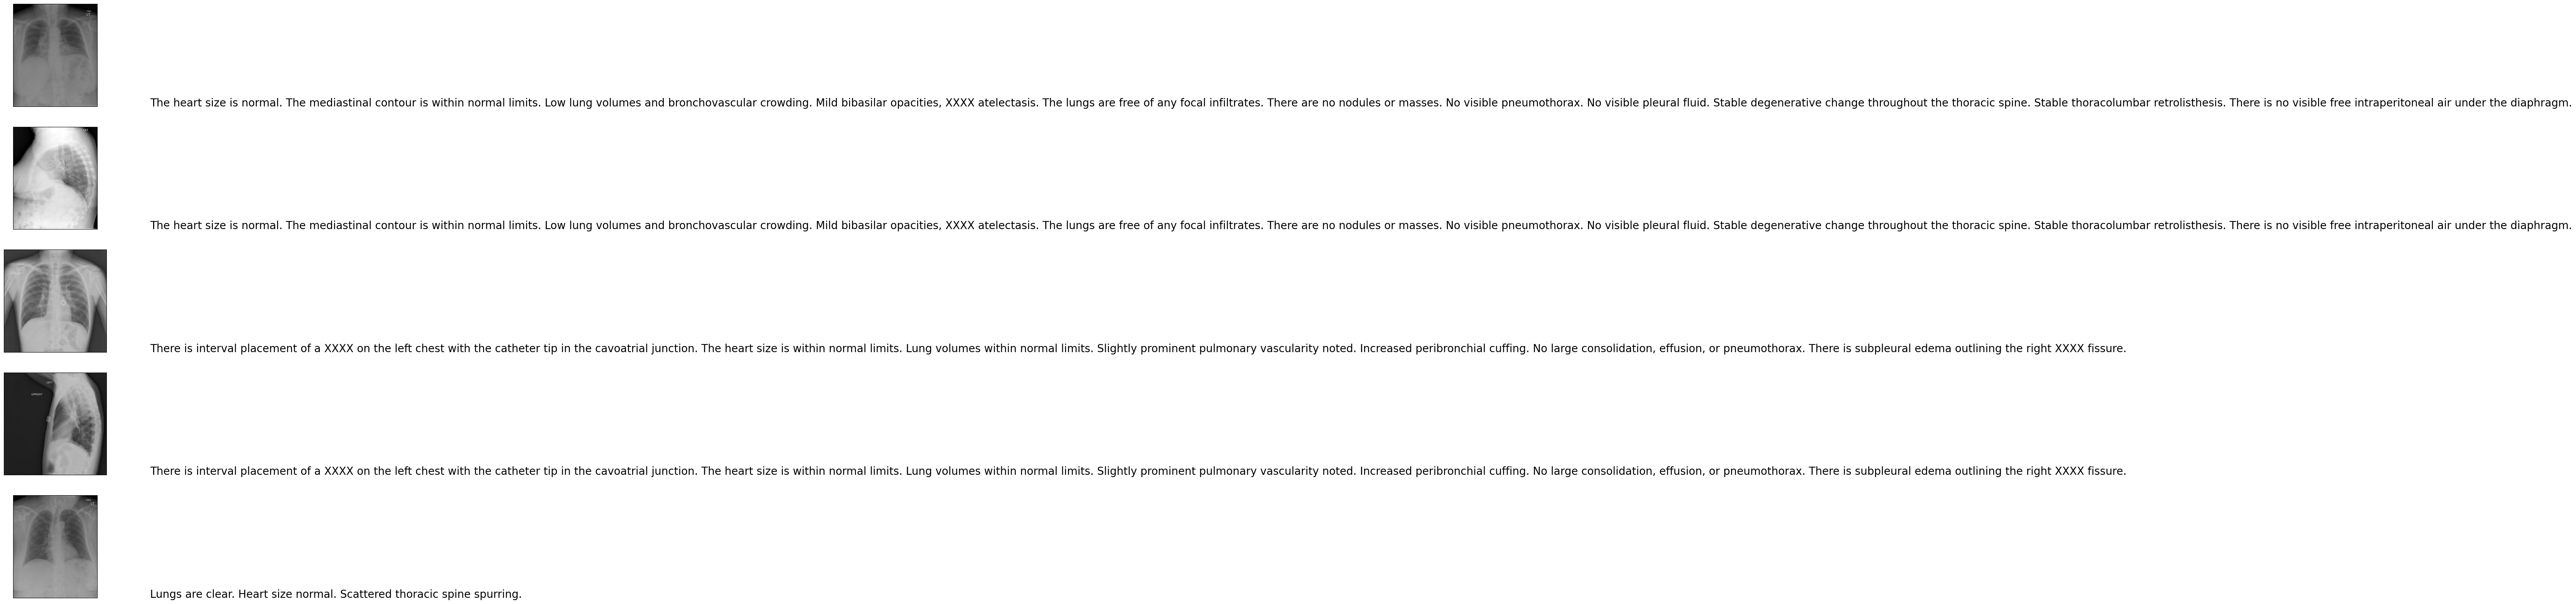

In [90]:
image_desc_plotter(dataset, 5, 'finding')

In [91]:
# loading the heights and widths of each image
h = []
w = []
for i in tqdm(np.unique(dataset['Image_path'].values)):
    img = cv2.imread(i)
    h.append(img.shape[0])
    w.append(img.shape[1])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7470/7470 [00:33<00:00, 225.09it/s]


<Axes: title={'center': 'Width Plot'}, xlabel='--Images--', ylabel='Widths'>

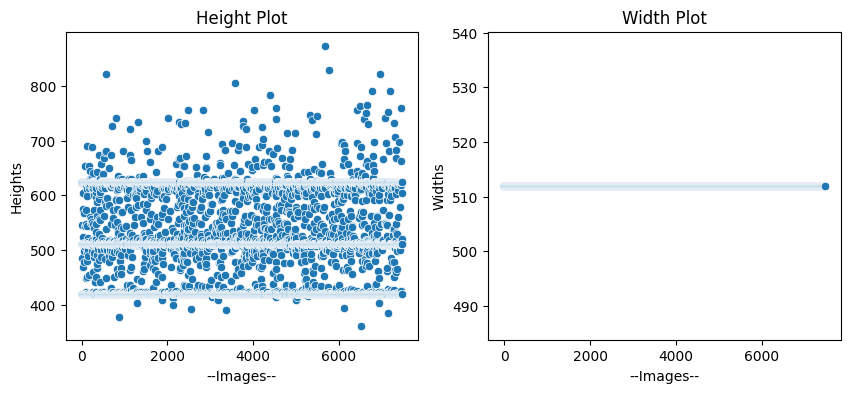

In [96]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title('Height Plot')
plt.ylabel('Heights')
plt.xlabel('--Images--')
# sns.scatterplot(range(len(h)), h)
sns.scatterplot(h)
plt.subplot(122)
plt.title('Width Plot')
plt.ylabel('Widths')
plt.xlabel('--Images--')
# sns.scatterplot(range(len(w)), h)
sns.scatterplot(w)


In [97]:
print('Number of Images:', dataset['Image_path'].nunique())

Number of Images: 7470


In [98]:
# number of missing values
dataset.isnull().sum()

Image_path      0
Finding       997
dtype: int64

In [99]:
dataset = dataset.dropna(axis=0)
dataset.isnull().sum()

Image_path    0
Finding       0
dtype: int64

In [100]:
print('New Shape of the Data:', dataset.shape)

New Shape of the Data: (6473, 2)


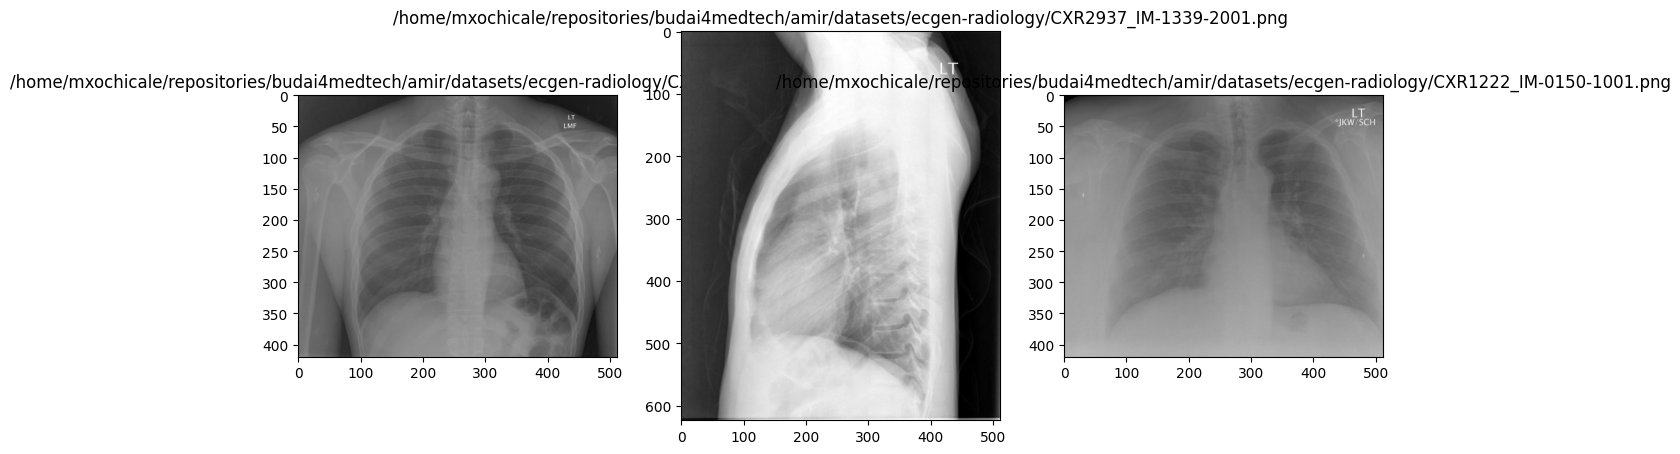

In [101]:
plt.figure(figsize=(14,7))
plt.subplot(131)
img1 = cv2.imread(dataset['Image_path'].values[6])
plt.imshow(img1)
plt.title(dataset['Image_path'].values[6])
plt.subplot(132)
img2 = cv2.imread(dataset['Image_path'].values[7])
plt.title(dataset['Image_path'].values[7])
plt.imshow(img2)
plt.subplot(133)
img3 = cv2.imread(dataset['Image_path'].values[8])
plt.title(dataset['Image_path'].values[8])
plt.imshow(img3)

In [102]:
dataset['Finding'].values[6], dataset['Finding'].values[7], dataset['Finding'].values[8]

('The heart size and mediastinal contours appear within normal limits. No focal airspace consolidation, pleural effusion or pneumothorax. No acute bony abnormalities.',
 'The heart size and mediastinal contours appear within normal limits. No focal airspace consolidation, pleural effusion or pneumothorax. No acute bony abnormalities.',
 'The heart and lungs have XXXX XXXX in the interval. Both lungs are clear and expanded. Heart and mediastinum normal.')

The dataset consists of multiple chest shots of the same person. The images of a person has the same file name except the last 4 digits. Therefore that can be taken as the person ID.

In [103]:
# This creates 2 dictionaries with keys as the person id and the number of images and findings for that person.
images = {}
findings = {}
for img, fin in dataset.values:
    a = img.split('-')
    a.pop(len(a)-1)
    a = '-'.join(e for e in a)
    if a not in images.keys():
        images[a] = 1
        findings[a] = fin
    else:
        images[a] += 1
        findings[a] = fin

In [105]:
# images['/content/drive/MyDrive/image/NLMCXR_png/CXR1808_IM-0524'], findings['/content/drive/MyDrive/image/NLMCXR_png/CXR1808_IM-0524']
images[directory+'/CXR1808_IM-0524'], findings[directory+'/CXR1808_IM-0524']


(2,
 'The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax. Multilevel flowing anterior thoracic spine osteophytes, which could represent changes of diffuse idiopathic skeletal hyperostosis (DISH).')

In [106]:
print('Total Number of Unique_IDs :', len(images.keys()))

Total Number of Unique_IDs : 3350


Text(0.5, 0, 'Number of Individuals in the Data')

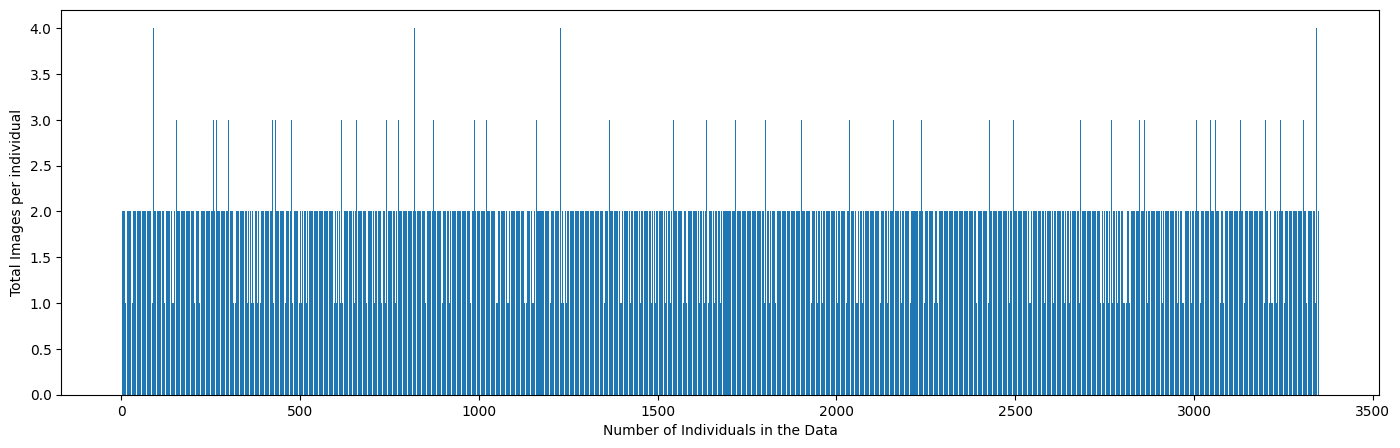

In [107]:
plt.figure(figsize=(17,5))
plt.bar(range(len(images.keys())), images.values())
plt.ylabel('Total Images per individual')
plt.xlabel('Number of Individuals in the Data')

In [108]:
one = 0
two = 0
three = 0
four = 0
for v in images.values():
    if v == 1:
        one +=1
    elif v == 2:
        two += 1
    elif v == 3:
        three += 1
    elif v == 4:
        four += 1
    else:
        print('Error')

In [109]:
one, two, three, four

(390, 2807, 143, 10)

In [110]:
len(images)

3350

In [111]:
def train_test_split(data):
    persons = list(data.keys())
    persons_train = persons[:2500]
    persons_cv = persons[2500:3000]
    persons_test = persons[3000:3350]
    return persons_train, persons_cv, persons_test

In [112]:
images_train, images_cv, images_test = train_test_split(images)

In [113]:
def combining_images(image_set):

    image_per_person = defaultdict(list)  # creating a list of dictionary to store all the image paths
                                            #corresponding to a person_id
    for pid in image_set:
        for img in dataset['Image_path'].values:
            if pid in img:
                image_per_person[pid].append(img)
            else:
                continue
    return image_per_person

In [114]:
img_per_person_train = combining_images(images_train)
img_per_person_cv = combining_images(images_cv)
img_per_person_test = combining_images(images_test)

In [115]:
len(img_per_person_train), len(images_train)

(2500, 2500)

In [116]:
def load_image(file):
    img = tf.io.read_file(file)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

Text(0.5, 1.0, '/home/mxochicale/repositories/budai4medtech/amir/datasets/ecgen-radiology/CXR1102_IM-0069-4004.png')

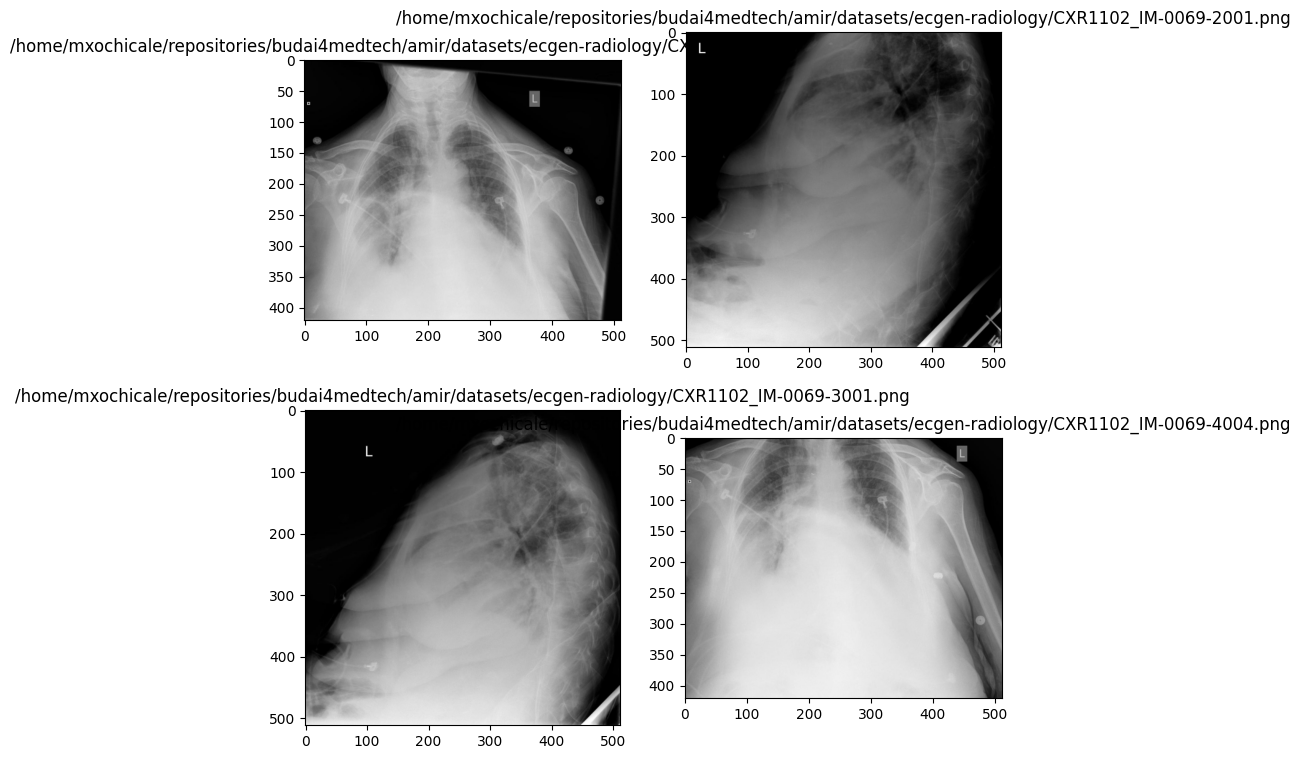

In [119]:

plt.figure(figsize=(9,9))
plt.subplot(221)
# plt.imshow(load_image('/content/drive/MyDrive/image/NLMCXR_png/CXR1102_IM-0069-12012.png'))
# plt.title('/content/drive/MyDrive/image/NLMCXR_png/CXR1102_IM-0069-12012.png')
plt.imshow(load_image(directory+'/CXR1102_IM-0069-12012.png'))
plt.title(directory+'/CXR1102_IM-0069-12012.png')

plt.subplot(222)
# plt.imshow(load_image('/content/drive/MyDrive/image/NLMCXR_png/CXR1102_IM-0069-2001.png'))
# plt.title('/content/drive/MyDrive/image/NLMCXR_png/CXR1102_IM-0069-2001.png')
plt.imshow(load_image(directory+'/CXR1102_IM-0069-2001.png'))
plt.title(directory+'/CXR1102_IM-0069-2001.png')

plt.subplot(223)
# plt.imshow(load_image('/content/drive/MyDrive/image/NLMCXR_png/CXR1102_IM-0069-3001.png'))
# plt.title('/content/drive/MyDrive/image/NLMCXR_png/CXR1102_IM-0069-3001.png')
plt.imshow(load_image(directory+'/CXR1102_IM-0069-3001.png'))
plt.title(directory+'/CXR1102_IM-0069-3001.png')

plt.subplot(224)
# plt.imshow(load_image('/content/drive/MyDrive/image/NLMCXR_png/CXR1102_IM-0069-4004.png'))
# plt.title('/content/drive/MyDrive/image/NLMCXR_png/CXR1102_IM-0069-4004.png')

plt.imshow(load_image(directory+'/CXR1102_IM-0069-4004.png'))
plt.title(directory+'/CXR1102_IM-0069-4004.png')


In [120]:
def create_data(image_per_person):
    # new dataset
    person_id, image1, image2, report = [],[],[],[]
    for pid, imgs in image_per_person.items():   #contains pid and the images associated with that pid

        if len(imgs) == 1:
            image1.append(imgs[0])
            image2.append(imgs[0])
            person_id.append(pid)
            report.append(findings[pid])
        else:
            num = 0
            a = itertools.combinations(imgs, 2)
            for i in a:
                image1.append(i[0])
                image2.append(i[1])
                person_id.append(pid + '_' + str(num))
                report.append(findings[pid])
                num += 1
    data = pd.DataFrame()
    data['Person_id'] = person_id
    data['Image1'] = image1
    data['Image2'] = image2
    data['Report'] = report

    return data

In [121]:
train = create_data(img_per_person_train)
test = create_data(img_per_person_test)
cv = create_data(img_per_person_cv)

In [122]:
train.head()

,Person_id,Image1,Image2,Report
0,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,There are diffuse bilateral interstitial and a...
1,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,The heart size and mediastinal contours appear...
2,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,The XXXX examination consists of frontal and l...
3,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,The heart size and mediastinal contours appear...
4,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,The heart and lungs have XXXX XXXX in the inte...


### Text Cleaning

In [123]:
def lowercase(text):
    '''Converts to lowercase'''
    new_text = []
    for line in text:
        new_text.append(line.lower())
    return new_text

def decontractions(text):
    '''Performs decontractions in the doc'''
    new_text = []
    for phrase in text:
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)
        phrase = re.sub(r"couldn\'t", "could not", phrase)
        phrase = re.sub(r"shouldn\'t", "should not", phrase)
        phrase = re.sub(r"wouldn\'t", "would not", phrase)
        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        phrase = re.sub(r"\*+", "abuse", phrase)
        new_text.append(phrase)

    return new_text

def rem_punctuations(text):
    '''Removes punctuations'''
    punctuations = '''!()-[]{};:'"\,<>/?@#$%^&*~''' # full stop is not removed
    new_text = []
    for line in text:
        for char in line:
            if char in punctuations:
                line = line.replace(char, "")
        new_text.append(' '.join(e for e in line.split()))
    return new_text

def rem_numbers(text):
    '''Removes numbers and irrelevant text like xxxx*'''
    new_text = []
    for line in text:
        temp = re.sub(r'x*','',line)
        new_text.append(re.sub(r'\d','',temp))
    return new_text

def words_filter(text):
    '''Removes words less than 2 characters except no and ct'''
    new_text = []
    for line in text:
        temp = line.split()
        temp2 = []
        for word in temp:
            if  len(word) <=2 and word != 'no' and word != 'ct':
                continue
            else:
                temp2.append(word)
        new_text.append(' '.join(e for e in temp2))
    return new_text

def multiple_fullstops(text):
    ''' Removes multiple full stops from the text'''
    new_text = []
    for line in text:
        new_text.append(re.sub(r'\.\.+', '.', line))
    return new_text

def fullstops(text):
    new_text = []
    for line in text:
        new_text.append(re.sub('\.', ' .', line))
    return new_text

def multiple_spaces(text):
    new_text = []
    for line in text:
        new_text.append(' '.join(e for e in line.split()))
    return new_text

def separting_startg_words(text):
    new_text = []
    for line in text:
        temp = []
        words = line.split()
        for i in words:
            if i.startswith('.') == False:
                temp.append(i)
            else:
                w = i.replace('.','. ')
                temp.append(w)
        new_text.append(' '.join(e for e in temp))
    return new_text

def rem_apostrophes(text):
    new_text = []
    for line in text:
        new_text.append(re.sub("'",'',line))
    return new_text

In [124]:
def text_preprocessing(text):
    '''Combines all the preprocess functions'''
    new_text = lowercase(text)
    new_text = decontractions(new_text)
    new_text = rem_punctuations(new_text)
    new_text = rem_numbers(new_text)
    new_text = words_filter(new_text)
    new_text = multiple_fullstops(new_text)
    new_text = fullstops(new_text)
    new_text = multiple_spaces(new_text)
    new_text = separting_startg_words(new_text)
    new_text = rem_apostrophes(new_text)
    return new_text

In [125]:
train['Report'] = text_preprocessing(train['Report'])
test['Report'] = text_preprocessing(test['Report'])
cv['Report'] = text_preprocessing(cv['Report'])

In [126]:
train.head()

,Person_id,Image1,Image2,Report
0,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,there are diffuse bilateral interstitial and a...
1,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,the heart size and mediastinal contours appear...
2,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,the eamination consists frontal and lateral ra...
3,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,the heart size and mediastinal contours appear...
4,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,/home/mxochicale/repositories/budai4medtech/am...,the heart and lungs have the interval . both ...


In [127]:
l = [len(e.split()) for e in train['Report'].values]  # Number of words in each report
max(l)

153

In [128]:
l = []
for i in train['Report'].values:
    l.extend(i.split())
c = Counter(l)
words = []
count = []
for k,v in c.items():
    words.append(k)
    count.append(v)
words_count = list(zip(count, words))
top_50_words = sorted(words_count)[::-1][:50]
bottom_50_words = sorted(words_count)[:50]

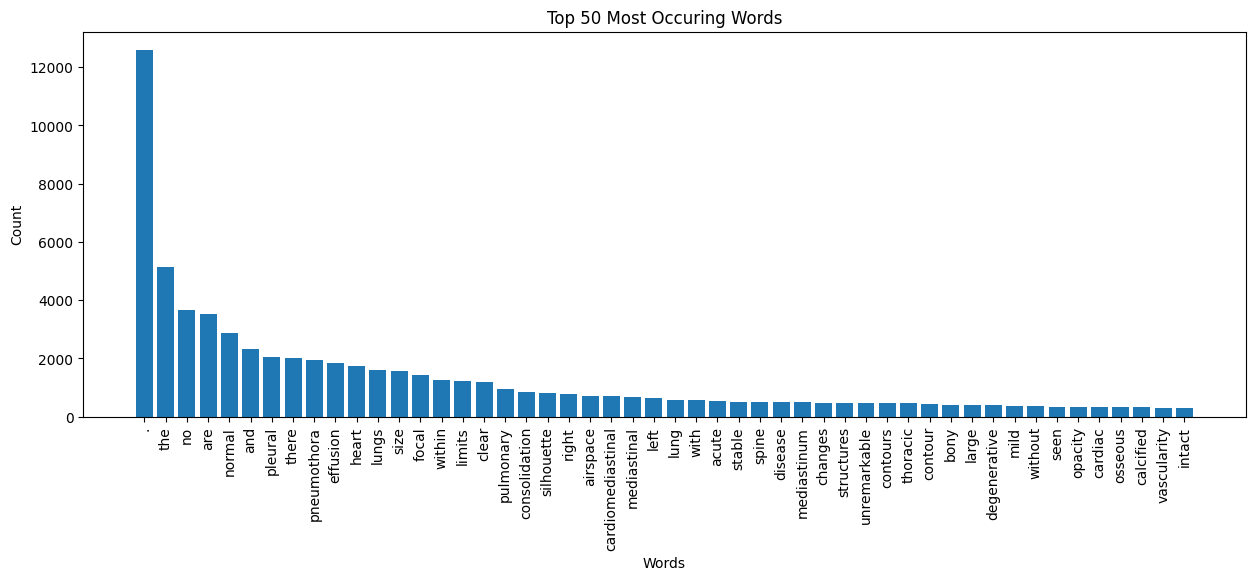

In [130]:
plt.figure(figsize=(15,5))
plt.bar(range(50), [c for c,w in top_50_words])
plt.title('Top 50 Most Occuring Words')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(ticks=range(50), labels=[w for c,w in top_50_words], rotation=90)
plt.show()

In [131]:
w = WordCloud(height=1500, width=1500).generate(str(l))

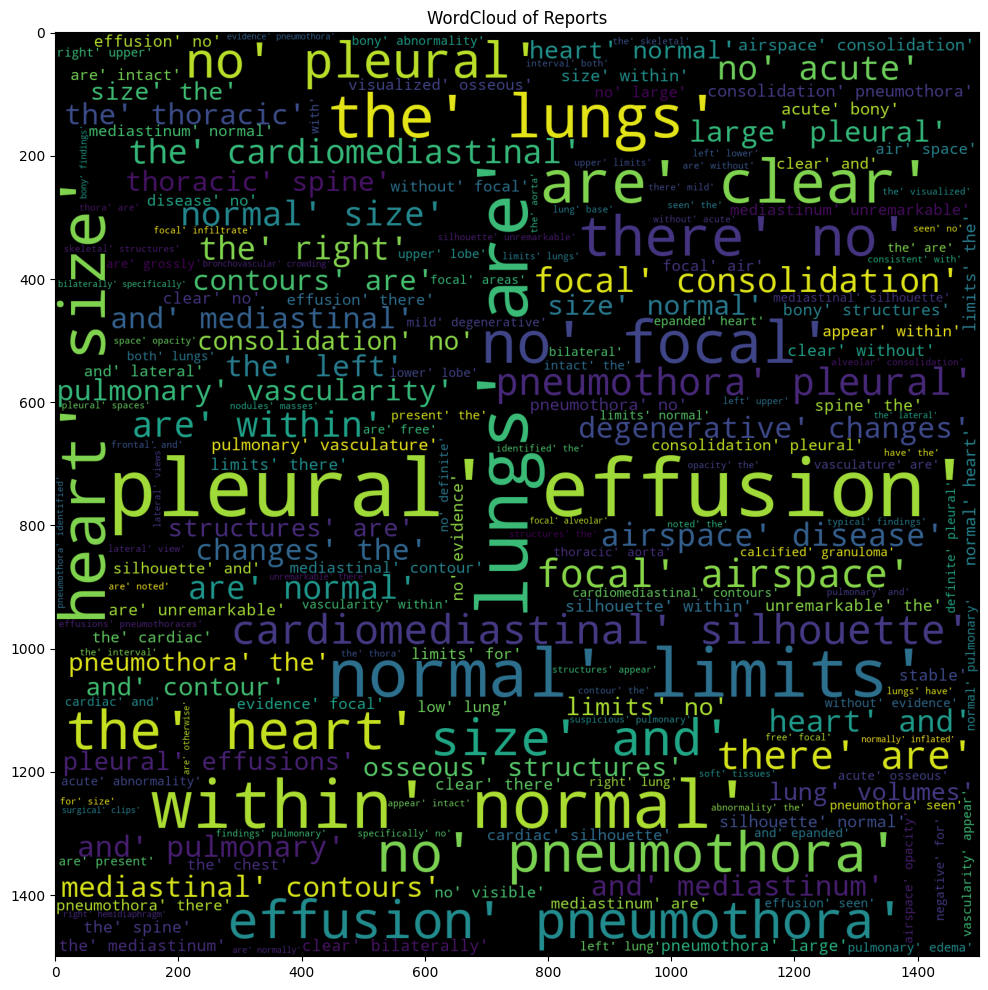

In [133]:
plt.figure(figsize=(12,12))
plt.title('WordCloud of Reports')
plt.imshow(w)
plt.show()

In [134]:
def remodelling(x):
    '''adds start and end tokens to a sentence '''
    return 'startseq' + ' ' + x + ' ' + 'endseq'

In [135]:
train['Report'] = train['Report'].apply(lambda x : remodelling(x))
test['Report'] = test['Report'].apply(lambda x : remodelling(x))
cv['Report'] = cv['Report'].apply(lambda x : remodelling(x))

In [136]:
# save the cleaned data(STRUCTURED DATA)
train.to_csv('Train_Data.csv', index=False)
test.to_csv('Test_Data.csv', index=False)
cv.to_csv('CV_Data.csv', index=False)